In [1]:
!pip install nltk
!pip install textblob
import nltk
import re
import csv
import pandas
from matplotlib import pyplot
import matplotlib.pyplot as pyplot
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import naive_bayes
from sklearn import tree
from sklearn import neighbors
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from collections import Counter


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


[nltk_data] Downloading package punkt to C:\Users\pablo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pablo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\pablo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Apartado 2. Limpieza de texto

In [2]:
#Función para obtener un texto limpio a patir de un texto normal
def limpiar_texto(texto):
    # Eliminar menciones, hashtags, URLs y otros símbolos extraños
    texto = re.sub(r'http\S+', '', texto)  # eliminar URLs
    texto = re.sub(r'#\w+', '', texto)  # eliminar hashtags
    texto = re.sub(r'@\w+', '', texto)  # eliminar menciones
    texto = re.sub(r'[^\w\s]', '', texto)  # eliminar otros símbolos extraños
    
    # Convertir el texto a minúsculas
    texto = texto.lower()
    
    # Tokenización
    tokens = word_tokenize(texto)
    
    # Eliminación de stop words y lematización
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    palabras_limpias = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    # Unir las palabras limpias en una sola cadena de texto
    texto_limpio = ' '.join(palabras_limpias)
    
    return texto_limpio


### Apartado 3. Etiquetado de texto

In [3]:
# Función para etiquetar un texto ya limpio
def etiquetar(texto):
    # Crear un objeto TextBlob con el texto a analizar
    blob = TextBlob(texto)
    # Obtener el valor del análisis de sentimiento
    sentimiento = blob.sentiment.polarity
    # Asignar una etiqueta en función del valor del sentimiento
    if sentimiento >= 0.7:
        etiqueta = "Muy feliz"
    elif sentimiento >= 0.2:
        etiqueta = "Contento"
    elif sentimiento >= -0.2:
        etiqueta = "Neutro"
    elif sentimiento >= -0.7:
        etiqueta = "Molesto"
    else:
        etiqueta = "Hater"
    return etiqueta

### Añadir datos al csv

In [4]:
def agregar_columna(input_file):
    with open(input_file, 'r') as file:
        reader = csv.reader(file, delimiter=';')
        rows = list(reader)
        header = rows[0]
        # Añadimos las 2 nuevas columnas del csv
        header.append('Texto limpio')
        header.append('Valor propuesto')
        for i in range(1, len(rows)):
            # Usamos la columna en la cuál está el texto en bruto
            valor_columna = rows[i][2]  
            # Limpiamos el texto para que pueda ser analizado
            texto_limpio = limpiar_texto(valor_columna)
            # Lo etiquetamos
            texto_etiquetado = etiquetar(texto_limpio)
            # Añadimos los nuevos valores
            rows[i].append(texto_limpio) 
            rows[i].append(texto_etiquetado)  

    # Guardar los cambios en un archivo sobre el que se va a trabajar a partir de ahora
    output_file = 'DatosFinales.csv'
    with open(output_file, 'w', newline='') as file:
        writer = csv.writer(file, delimiter=';')
        writer.writerows(rows)

In [5]:
agregar_columna('DatosAEditar.csv')

In [6]:
csvDatos = pandas.read_csv('DatosFinales.csv', delimiter=';',encoding = 'latin-1', header=0,
                       names=['id', 'valoración', 'mensaje', 'texto_limpio',
                              'valor_propuesto'])

### Selección de atributos y objetivos

In [7]:
atributo = csvDatos['texto_limpio'].values.astype('U')  # selección de las columnas de atributos
objetivo = csvDatos['valor_propuesto']  # selección de la columna objetivo

In [8]:
# Usamos CountVectorizer para codificar el texto debido a que es el mejor 
# codificador a la hora de usar cadenas de texto puesto que no son etiquetas ni números
codificador_atributo = CountVectorizer()

# Para codificar el objetivo usamos LabelEncoder debido a que solo puede tomar
# 5 valores, es decir, etiquetas
codificador_objetivo = preprocessing.LabelEncoder()

atributo_codificado = codificador_atributo.fit_transform(atributo)
objetivo_codificado = codificador_objetivo.fit_transform(objetivo)

In [9]:
# Vemos el porcentaje de entradas que tienen las distintas etiquetas
print(pandas.Series(objetivo).value_counts(normalize=True))

Neutro       0.58994
Contento     0.18002
Molesto      0.16408
Muy feliz    0.03634
Hater        0.02962
Name: valor_propuesto, dtype: float64


### Apartado 5. Entrenamiento del modelo

In [10]:
(atributo_entrenamiento, atributo_prueba,
 objetivo_entrenamiento, objetivo_prueba) = model_selection.train_test_split(
        # Conjuntos de datos a dividir, usando los mismos índices para ambos
        atributo_codificado, objetivo_codificado,
        # Valor de la semilla aleatoria, para que el muestreo sea reproducible,
        # a pesar de ser aleatorio
        random_state=12345,
        # Tamaño del conjunto de prueba
        test_size=.33,
        # Estratificamos respecto a la distribución de valores en la variable objetivo
        stratify=objetivo_codificado)

In [11]:
# Comprobamos que el conjunto de prueba contiene el 33 % de los datos, en la misma proporción
# con respecto a la variable objetivo
print('Cantidad de ejemplos de pruebas requeridos:', 50000 * .33)
print('Filas del array de atributos de prueba:', atributo_prueba.shape[0])
print('Longitud del vector de objetivos de prueba:', len(objetivo_prueba))
print('Proporción de clases en el vector de objetivos de prueba:')
print(pandas.Series(
        codificador_objetivo.inverse_transform(objetivo_prueba)
      ).value_counts(normalize=True))

Cantidad de ejemplos de pruebas requeridos: 16500.0
Filas del array de atributos de prueba: 16500
Longitud del vector de objetivos de prueba: 16500
Proporción de clases en el vector de objetivos de prueba:
Neutro       0.589939
Contento     0.180000
Molesto      0.164061
Muy feliz    0.036364
Hater        0.029636
dtype: float64


In [12]:
# Comprobamos que el conjunto de entrenamiento contiene el resto de los datos, en la misma
# proporción con respecto a la variable objetivo
print('Cantidad de ejemplos de entrenamiento requeridos:', 50000 * .67)
print('Filas del array de atributos de entrenamiento:', atributo_entrenamiento.shape[0])
print('Longitud del vector de objetivos de entrenamiento:', len(objetivo_entrenamiento))
print('Proporción de clases en el vector de objetivos de entrenamiento:')
print(pandas.Series(
        codificador_objetivo.inverse_transform(objetivo_entrenamiento)
      ).value_counts(normalize=True))

Cantidad de ejemplos de entrenamiento requeridos: 33500.0
Filas del array de atributos de entrenamiento: 33500
Longitud del vector de objetivos de entrenamiento: 33500
Proporción de clases en el vector de objetivos de entrenamiento:
Neutro       0.589940
Contento     0.180030
Molesto      0.164090
Muy feliz    0.036328
Hater        0.029612
dtype: float64


In [13]:
nuevos_ejemplos = pandas.DataFrame([['im really sick fever'],
                                    ['im happy family friends']], columns=['texto_limpio'])
nuevos_ejemplos

,texto_limpio
0,im really sick fever
1,im happy family friends


### Prueba Naive Bayes

In [14]:
clasif_NB = naive_bayes.MultinomialNB(alpha=0.5)
clasif_NB.fit(atributo_entrenamiento, objetivo_entrenamiento)

MultinomialNB(alpha=0.5)

In [15]:
predicciones = clasif_NB.predict(codificador_atributo.transform(nuevos_ejemplos['texto_limpio']))
codificador_objetivo.inverse_transform(predicciones)

array(['Neutro', 'Contento'], dtype=object)

In [16]:
clasif_NB.score(atributo_prueba, objetivo_prueba)

0.6706666666666666

### Prueba Árboles de Decisión

In [17]:
clasif_CART = tree.DecisionTreeClassifier(
    max_depth=10,  # máxima profundidad del árbol
    random_state=54321  # semilla aleatoria, para que el código sea reproducible
)
clasif_CART.fit(atributo_entrenamiento, objetivo_entrenamiento)

DecisionTreeClassifier(max_depth=10, random_state=54321)

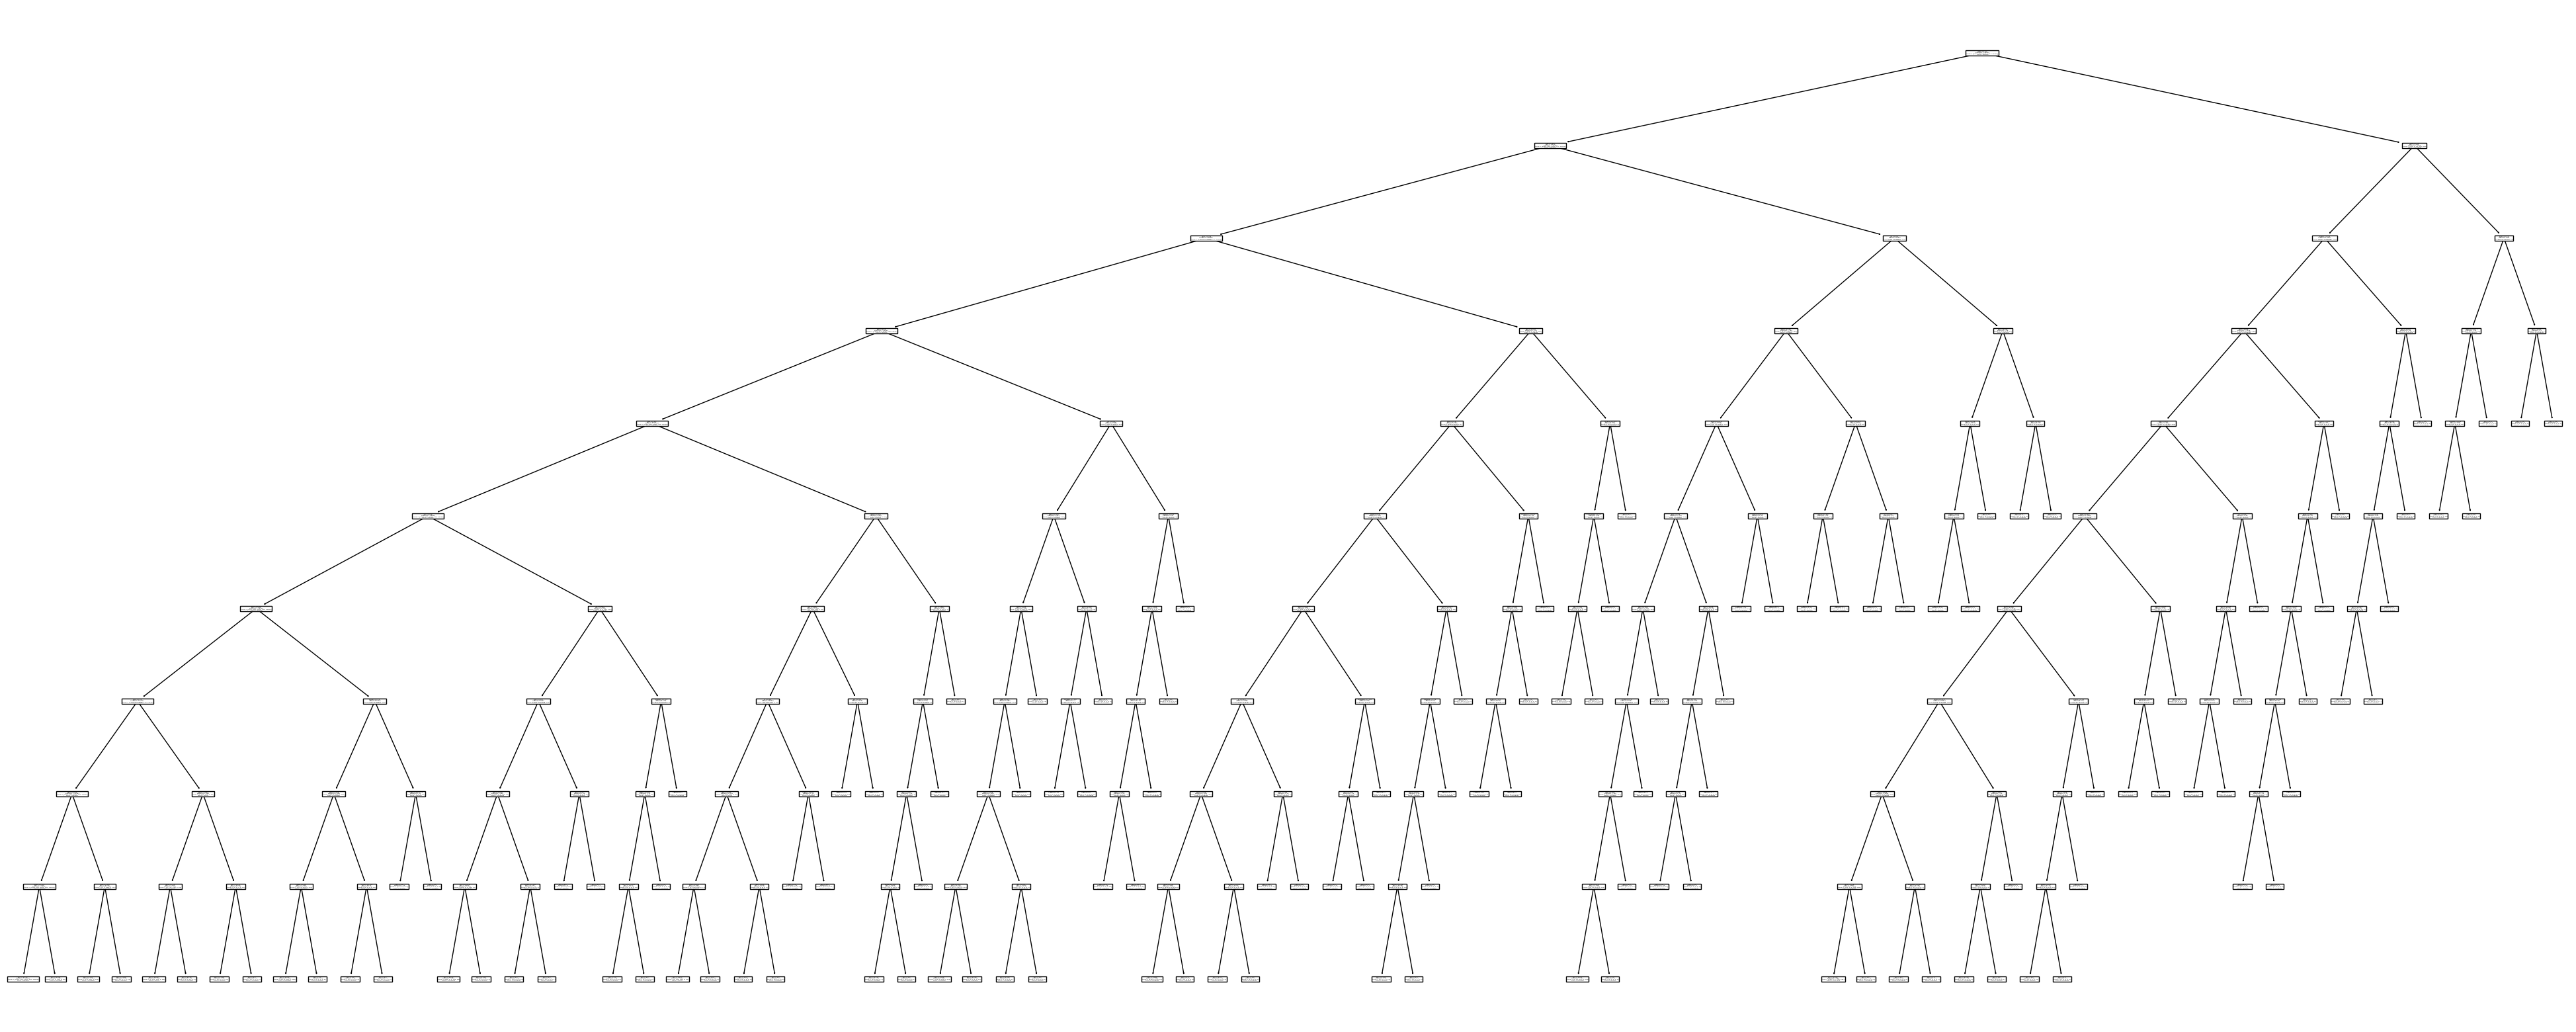

In [18]:
pyplot.figure(figsize=(50, 20))  # Anchura y altura del gráfico
árbol = tree.plot_tree(clasif_CART,
                       feature_names=codificador_atributo.get_feature_names_out(),
                       class_names=codificador_objetivo.classes_)

In [19]:
predicciones = clasif_CART.predict(codificador_atributo.transform(nuevos_ejemplos['texto_limpio']))
codificador_objetivo.inverse_transform(predicciones)

array(['Hater', 'Neutro'], dtype=object)

In [20]:
clasif_CART.score(atributo_prueba, objetivo_prueba)

0.6703636363636364

### Prueba KNN

In [21]:
clasif_kNN = neighbors.KNeighborsClassifier(
    n_neighbors=5,  # Número de vecinos a considerar
    metric='euclidean'  # Distancia de Hamming como métrica de cercanía:
                      # fracción de atributos con valores distintos
)
clasif_kNN.fit(atributo_entrenamiento, objetivo_entrenamiento)

KNeighborsClassifier(metric='euclidean')

In [22]:
distancias, vecinos = clasif_kNN.kneighbors(codificador_atributo.transform(nuevos_ejemplos['texto_limpio']))

In [23]:
# Vecinos más cercanos y distancia a ellos del primer ejemplo nuevo
print("Primer ejemplo nuevo:")
print(nuevos_ejemplos.iloc[[0]])
print()
print("5 vecinos más cercanos:")
print(pandas.DataFrame(codificador_atributo.inverse_transform(atributo_entrenamiento[vecinos[0]]),
                       index=vecinos[0]).assign(
    distancia=distancias[0],
    clase=codificador_objetivo.inverse_transform(objetivo_entrenamiento[vecinos[0]])
))

Primer ejemplo nuevo:
           texto_limpio
0  im really sick fever

5 vecinos más cercanos:
        0       1      2          3           4  distancia   clase
30030  im    sick   None       None        None   1.414214   Hater
27875  im    sick  fever  todayhave        None   1.414214   Hater
26585  im  really   sick      tummy        None   1.414214   Hater
18839  im  really   sick         xd  quarantine   1.732051   Hater
25127  im   great   sick       None        None   1.732051  Neutro


In [24]:
# Vecinos más cercanos y distancia a ellos del segundo ejemplo nuevo
print("Segundo ejemplo nuevo:")
print(nuevos_ejemplos.iloc[[1]])
print()
print("5 vecinos más cercanos:")
print(pandas.DataFrame(codificador_atributo.inverse_transform(atributo_entrenamiento[vecinos[1]]),
                       index=vecinos[1]).assign(
    distancia=distancias[1],
    clase=codificador_objetivo.inverse_transform(objetivo_entrenamiento[vecinos[1]])
))

Segundo ejemplo nuevo:
              texto_limpio
1  im happy family friends

5 vecinos más cercanos:
           0      1  distancia      clase
4262      im  happy   1.000000  Muy feliz
20191     im   None   1.414214     Neutro
29806     im   None   1.414214     Neutro
20761     im   None   1.414214     Neutro
2459   happy   None   1.414214  Muy feliz


In [25]:
predicciones = clasif_kNN.predict(codificador_atributo.transform(nuevos_ejemplos['texto_limpio']))
codificador_objetivo.inverse_transform(predicciones)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


array(['Hater', 'Neutro'], dtype=object)

In [26]:
clasif_kNN.score(atributo_prueba, objetivo_prueba)

0.6572727272727272

### Validación cruzada de los métodos

In [27]:
#Para Naives Bayes
#creo un diccionario vacio
cv_scores_NB = {}
for k in range(1,11):
    #creo una instancia de modelo Naives Bayes para cada valor de suavizado (del 1 al 10, 11 porque python no coge el último)
    clasif_NB = naive_bayes.MultinomialNB(alpha=k)
    #guardo en cv_scores el resultado de cross_val_score que va hacer una validacion cruzada para cada suavizado
    cv_scores = model_selection.cross_val_score(clasif_NB,
                                                atributo_entrenamiento,
                                                objetivo_entrenamiento,
                                                cv=10)
    #lo guardo en el diccionario clave=suavizado, valor=media del resultado de la validacion cruzada para ese suavizado.
    cv_scores_NB[k] = cv_scores.mean()
    
print(cv_scores_NB)
mejor_k_NB = max(cv_scores_NB, key=cv_scores_NB.get)
print(f'Mejor suavizado: {mejor_k_NB}')

{1: 0.6528358208955224, 2: 0.6259402985074626, 3: 0.6135820895522388, 4: 0.6071940298507462, 5: 0.6028656716417912, 6: 0.599910447761194, 7: 0.5980597014925373, 8: 0.596865671641791, 9: 0.596358208955224, 10: 0.5958507462686566}
Mejor suavizado: 1


In [28]:
#Para arboles de decisión con CART
#Tarda entre 3 y 5 minutos
cv_scores_CART = {}
for p in range(1,11):
    clasif_CART = tree.DecisionTreeClassifier(max_depth=p)
    cv_scores = model_selection.cross_val_score(clasif_CART,
                                                atributo_entrenamiento,
                                                objetivo_entrenamiento,
                                                cv=10)
    cv_scores_CART[p] = cv_scores.mean()
print(cv_scores_CART)
mejor_p_CART = max(cv_scores_CART, key=cv_scores_CART.get)
print(f'Mejor profundidad: {mejor_p_CART}')

{1: 0.5953731343283583, 2: 0.6075820895522388, 3: 0.6179701492537313, 4: 0.6313432835820895, 5: 0.6393731343283581, 6: 0.6471641791044777, 7: 0.6560298507462686, 8: 0.6607761194029851, 9: 0.6674029850746269, 10: 0.6734925373134328}
Mejor profundidad: 10


In [29]:
#Para modelo kNN
cv_scores_kNN = {}
for k in range(1,11):
    clasif_kNN = neighbors.KNeighborsClassifier(n_neighbors=k, metric='euclidean') 
    cv_scores = model_selection.cross_val_score(clasif_kNN,
                                                atributo_entrenamiento,
                                                objetivo_entrenamiento,
                                                cv=10)
    cv_scores_kNN[k] = cv_scores.mean()
print(cv_scores_kNN)
mejor_k_kNN = max(cv_scores_kNN, key=cv_scores_kNN.get)
print(f'Mejor número de vecinos: {mejor_k_kNN}')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

{1: 0.6723582089552239, 2: 0.6673432835820895, 3: 0.6688656716417911, 4: 0.6751940298507462, 5: 0.6602985074626867, 6: 0.6688059701492537, 7: 0.6577313432835821, 8: 0.6623582089552238, 9: 0.6558208955223881, 10: 0.6579402985074626}
Mejor número de vecinos: 4


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


### Apartado 6. Predicción de tweets

In [30]:
clasif_kNN = neighbors.KNeighborsClassifier(n_neighbors=mejor_k_kNN, metric='euclidean')
clasif_kNN.fit(atributo_entrenamiento, objetivo_entrenamiento)
clasif_kNN.score(atributo_prueba, objetivo_prueba)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


0.6746666666666666

El acierto es del 67%

### Apartado 7. Análisis de tweets de personajes públicos

Tomaremos como Hater al usuario @kirawontmiss que es un personaje público con más de 1 millón de seguidores que suele criticar noticias actuales

In [31]:
mensajes_negativos = pandas.DataFrame([
['why the FUCK are we even still paying bills?? the world is literally ending'],
['YEAH THIS IS GETTING SO BAD.. WHAT THE FUCK DO U MEAN HAZARDOUS ??'],
['LMFAOOO pixar deleted the tweet'],
['yeah society is FINISHED.. mfs are really comparing wildfires'],
['this gotta be the worst time to post this tweet LMAOO https://twitter.com/pixar/status/1666520608107298817'],
['who the fuck owns Kick they are out here giving out NBA contracts'],
['i had no problem with eminem until this horrible video dropped'],
['SO THIS WASNT A JOKE???'],
['FINALLY WE ARE FREE'],
['nothing could’ve prepared me for the ending'],
['why the fuck don’t they jump over moving cars like this'],
['LMAOO bro had the entire theater laughing'],
['usually people hate when someone does this im surprised he got everyone laughing 😭'],
['do you know how unlucky you have to be for some shit like this to happen to you LMAOO'],
['for $3499 that shit better let me see into the future wtf'],
['why she dressed like a condom before you put it on LMAOOO'],
['LMFAOOOOOO boruto didn’t influence shit'],
['world war 2 is over.. y’all don’t have to eat like this anymore'],
['he’s useless as fuck'],
['WHAT THE FUCKKK THIS SHlT IS A MASTERPIECE'],
['the way drake said embarrassing is exactly how i expected him to say it'],
['why are you holding the drinks like this'],
['Ai is gonna have y’all fucked up'],
['IM NOT MAKING IT'],
['alright its been 7 years who the fuck was behind those clowns costumes back in 2016'],
['this is easily the worst genre of anime'],
['LMFAOOO evil ass laugh'],
['that person gonna watch the movie like this']], columns=['texto_limpio'])
mensajes_negativos_limpios = []
for mensaje in mensajes_negativos.values:
    mensajes_negativos_limpios.append(limpiar_texto(mensaje[0]))
mensajes_negativos_limpios1 = pandas.DataFrame(mensajes_negativos_limpios,columns=['texto_limpio'])

Tomaremos como usuario positivo al futbolista @ErlingHaaland que es un delantero noruego del equipo inglés Manchester City que durante esta temporada ha ganado todo los títulos posibles y ha sido máximo goleador histórico de la liga inglesa, por lo que ha sido un año positivo para él.

In [32]:
mensajes_positivos = pandas.DataFrame([
['One more @BVB'],
['Honoured to win such an incredibly prestigious award  @theofficialfwa Thank you to all those who voted for me. Obviously, this wouldnt have been possible without the unbelievable support I have from everyone at @ManCity'],
['Thanks to everyone for the support and love, these memories will last a lifetime!'],
['Me and my baby'],
['Always give your best. Always believe. It pays off. CMON CITY! '],
['💯 Focus on tomorrow'],
['Thank you! Busy morning 😅'],
['Thank you everyone! 🙌🏻'],
['Thank you 🙏🏻 and congratulations to back-to-back winner @samkerr1, amazing achievement!'],
['Thank you 🙏🏻'],
['It’s all in our hands... Can’t wait for the game next week! 🔜'],
['Job done, looking forward to Tuesday! 👊🏻'],
['Friend: how many league goals have you scored? Me:'],
['@ErlingHaaland was Born to Goal. To celebrate his phenomenal @PremierLeague goalscoring record we created a unique phenomenon in the skies of Manchester. #Force9 #nikefc'],
['A night to remember! 💙'],
['35 Premier League goals 🤩 A big thank you to everyone for the support, nothing happens without you all, we dont stop here! 💙'],
['We fight!'],
['Cannot. Wait. 🔵 #mancity'],
['Through to the final! 🔵 #mancity #FACup'],
['Destiny is ALL 🔵 #mancity'],
['Semis here we come! 💙 thanks to all our travelling fans for the support #mancity #UCL'],
['Big week of results! 🔵 #mancity'],
['Me and my magic potion 🥛💪🏻'],
['Nothing but pure love for this competition! 🔵 #mancity #UCL'],
['Wishing everyone celebrating a Happy Easter! 🐰 I hope you enjoy the special day with your loved ones! 🙏🏻'],
['Back on the pitch! ⚡️🔵 #mancity'],
['Good old days'],
['Wishing everyone a happy, healthy & bright #ChineseNewYear! ✨'],
['Positive spirit! 🔵 #mancity'],
['What a team performance! Fans were unreal, thanks for being our 12th man 💙 #mancity'],
['Very happy to get this achievement where it all started for me. 20 PL goals, and looking forward to many more! ☝🏻🤖🔵 #mancity'],
['A special game for me last night, was great to be back to Leeds 🔵 #mancity']],columns=['texto_limpio'])
mensajes_positivos_limpios = []
for mensaje in mensajes_positivos.values:
    mensajes_positivos_limpios.append(limpiar_texto(mensaje[0]))
mensajes_positivos_limpios1 = pandas.DataFrame(mensajes_positivos_limpios,columns=['texto_limpio'])

In [33]:
predicciones_negativas = clasif_kNN.predict(codificador_atributo.transform(mensajes_negativos_limpios1['texto_limpio']))
array_negativo = codificador_objetivo.inverse_transform(predicciones_negativas)
array_negativo

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


array(['Molesto', 'Molesto', 'Neutro', 'Neutro', 'Neutro', 'Molesto',
       'Neutro', 'Neutro', 'Neutro', 'Neutro', 'Neutro', 'Neutro',
       'Hater', 'Neutro', 'Neutro', 'Neutro', 'Neutro', 'Neutro',
       'Molesto', 'Neutro', 'Neutro', 'Neutro', 'Neutro', 'Neutro',
       'Molesto', 'Neutro', 'Neutro', 'Neutro'], dtype=object)

In [34]:
predicciones_positivas = clasif_kNN.predict(codificador_atributo.transform(mensajes_positivos_limpios1['texto_limpio']))
array_positivo = codificador_objetivo.inverse_transform(predicciones_positivas)
array_positivo

array(['Neutro', 'Neutro', 'Contento', 'Neutro', 'Neutro', 'Neutro',
       'Neutro', 'Neutro', 'Neutro', 'Neutro', 'Neutro', 'Neutro',
       'Neutro', 'Neutro', 'Muy feliz', 'Neutro', 'Neutro', 'Neutro',
       'Neutro', 'Neutro', 'Contento', 'Neutro', 'Neutro', 'Neutro',
       'Neutro', 'Neutro', 'Muy feliz', 'Muy feliz', 'Neutro', 'Contento',
       'Neutro', 'Neutro'], dtype=object)

In [35]:
diccionario_negativos = dict(Counter(array_negativo))
diccionario_positivos = dict(Counter(array_positivo))
claves_negativas = list(diccionario_negativos.keys())
claves_positivas = list(diccionario_positivos.keys())
valores_negativos = list(diccionario_negativos.values())
valores_positivos = list(diccionario_positivos.values())

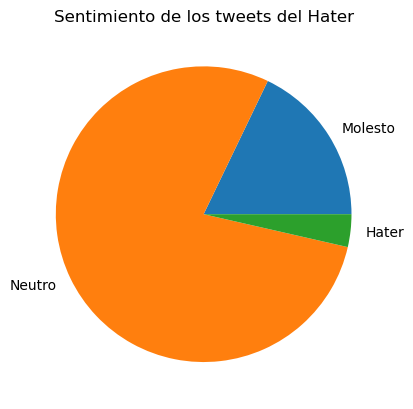

In [36]:
pyplot.pie(valores_negativos, labels=claves_negativas)
pyplot.title('Sentimiento de los tweets del Hater')
pyplot.show()

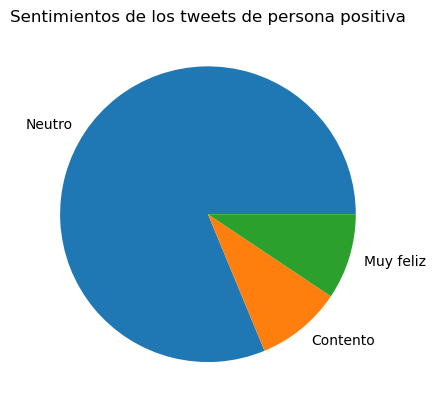

In [37]:
pyplot.pie(valores_positivos, labels=claves_positivas)
pyplot.title('Sentimientos de los tweets de persona positiva')
pyplot.show()